In [ ]:
!pip install -e ..[dev]

## Data Loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

from instaffo_matching.data.loader import load_data, get_matching_dataframes
from instaffo_matching.data.preprocessor import standardize_data
from instaffo_matching.features.engineer import FeatureEngineer

# Load data
data = load_data("../data/data.json")
talent_df, job_df, labels_df = get_matching_dataframes(data=data)

In [2]:
# Encodes categorical variables (degree, seniority, languages) into numerical values.
# This will be akin to ordinal encoding, preserves the relationships among categories
# Normalizes the data for machine learning model compatibility.
talent_df, job_df = standardize_data(talent_df, job_df)

### Feature Engineering

- I will explicitly here show the feature engineering class **for the sake of explanability of notebook**
- In training scripts, this would be done from importing the class from the package

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

from typing import List, Dict

class FeatureEngineer:
    """
    A class to engineer features for the matching/ranking model.

    This class handles:
    - Extraction and transformation of features from talent and job data.
    - Vectorization of textual data using TF-IDF.
    - Scaling and encoding of features for machine learning models.

    Attributes:
        job_role_vectorizer (TfidfVectorizer): Vectorizer for job roles using TF-IDF.
        preprocessor (ColumnTransformer): Preprocessing pipeline for feature scaling and encoding.
        num_feature_names (List[str]): Names of numerical features.
        cat_feature_names (List[str]): Names of categorical features.
        feature_names (List[str]): Names of all features after preprocessing.
    """

    def __init__(self):
        self.job_role_vectorizer = TfidfVectorizer()
        self.preprocessor = None 
        
        # for feature importance
        self.feature_names = None
        self.num_feature_names = [
            'language_match_score',
            'role_similarity',
            'degree_diff',
            'salary_difference_percentage',
            'max_seniority_diff',
            'salary_expectation',
            'salary_ratio'
        ]
        
        self.cat_feature_names = [
            'talent_seniority',
            'job_max_seniority',
            'job_min_seniority',
            'talent_degree',
            'job_min_degree',
            'seniority_match',
            'salary_comparison',
            'degree_match_highest'
        ]
        
    def fit(self, job_df: pd.DataFrame, talent_df: pd.DataFrame):
        """
        Fits the feature engineer on the provided data.

        - Fits the TF-IDF vectorizer on the combined job and talent roles.
        - Prepares a preprocessing pipeline for scaling and encoding.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.
        """
        # Fit TF-IDF vectorizer on job roles
        all_job_roles = job_df['job_roles'].apply(' '.join) + ' ' + talent_df['job_roles'].apply(' '.join)
        self.job_role_vectorizer.fit(all_job_roles)
        
        # Engineer features to get all categorical and numerical features
        features, categorical_features = self.engineer_features(job_df, talent_df)
        
        # Define the preprocessing pipeline
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), list(range(features.shape[1]))),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
                 list(range(features.shape[1], features.shape[1] + categorical_features.shape[1])))
            ]
        )
        
        # Fit the preprocessor on the combined features
        combined_features = np.hstack((features, categorical_features))
        self.preprocessor.fit(combined_features)
        
        # Get feature names
        cat_encoder = self.preprocessor.named_transformers_['cat']
        cat_feature_names = []
        for i, feature in enumerate(self.cat_feature_names):
            feature_categories = cat_encoder.categories_[i]
            for category in feature_categories:
                cat_feature_names.append(f"{feature}_{category}")
        
        self.feature_names = self.num_feature_names + cat_feature_names
    
    def get_feature_names(self):
        """
        Returns the names of the engineered features. This is useful for interpreting feature importance.
        """
        if self.feature_names is None:
            raise ValueError("FeatureEngineer has not been fitted yet.")
        return self.feature_names
    
    def transform(self, job_df: pd.DataFrame, talent_df: pd.DataFrame) -> np.ndarray:
        """
        Transforms the data using the fitted preprocessor and vectorizer.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.

        Returns:
            np.ndarray: Transformed feature matrix.
        """
        features, categorical_features = self.engineer_features(job_df, talent_df)
        combined_features = np.hstack((features, categorical_features))
        return self.preprocessor.transform(combined_features)
    
    def fit_transform(self, job_df: pd.DataFrame, talent_df: pd.DataFrame) -> np.ndarray:
        """
        Fits the preprocessor and transforms the data.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.

        Returns:
            np.ndarray: Transformed feature matrix.
        """
        self.fit(job_df, talent_df)
        return self.transform(job_df, talent_df)
        
    def engineer_features(self, job_df: pd.DataFrame, talent_df: pd.DataFrame):
        """
        Engineers features from job and talent data.

        - Computes numerical and categorical features.
        - Extracts job role similarity using TF-IDF.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.

        Returns:
            pd.DataFrame: DataFrame containing engineered features.
        """
        numerical_features = []
        categorical_features = []
        
        for idx in job_df.index:
            job = job_df.loc[idx]
            talent = talent_df.loc[idx]
            
            # Language match score
            language_match_score = self._calculate_language_match(talent['languages'], job['languages'])
            
            # Job role similarity using TF-IDF and cosine similarity
            talent_roles = ' '.join(talent['job_roles'])
            job_roles = ' '.join(job['job_roles'])
            role_similarity = self._calculate_role_similarity(talent_roles, job_roles)
            
            # Salary expectation features
            salary_ratio = talent['salary_expectation'] / job['max_salary']
            salary_comparison = 1 if talent['salary_expectation'] > job['max_salary'] else 0
            salary_difference_percentage = (talent['salary_expectation'] - job['max_salary']) / job['max_salary']
            # salary_competitive = (talent['salary_expectation'] <= job['max_salary']) * calculate_competitiveness_index(job['max_salary'], job['job_roles'])

            # Seniority features
            max_seniority = max(sen for sen in job['seniorities'])
            min_seniority = min(sen for sen in job['seniorities'])
            seniority_match = 1 if talent['seniority'] in job['seniorities'] else 0
            # seniority_match_highest = 1 if talent['seniority'] >= max_seniority else 0
            max_seniority_diff = max_seniority - talent['seniority']
            
            # Degree features
            degree_match_highest = 1 if talent['degree'] > job['min_degree'] else 0
            degree_diff = talent['degree'] - job['min_degree']
            

            # Collect numerical features
            numerical_feature_vector = [
                language_match_score,
                role_similarity,
                degree_diff,
                salary_difference_percentage,
                max_seniority_diff,
                talent['salary_expectation'],
                salary_ratio
            ]
            
            # Collect categorical features
            categorical_feature_vector = [
                talent['seniority'],
                max_seniority,
                min_seniority,
                talent['degree'],
                job['min_degree'],
                seniority_match,
                salary_comparison,
                degree_match_highest
            ]
            
            numerical_features.append(numerical_feature_vector)
            categorical_features.append(categorical_feature_vector)
                
        return np.array(numerical_features), np.array(categorical_features)
    
    def _calculate_language_match(self, talent_languages: List[Dict], job_languages: List[Dict]) -> float:
        """
        Calculates the language match score between talent and job. Since must-have languages are
        already filtered, this function computes the match score based on the ratings of prefered and
        required languages.

        Args:
            talent_languages (List[Dict]): List of languages with ratings for the talent.
            job_languages (List[Dict]): List of languages with ratings for the job.

        Returns:
            float: Normalized language match score.
        """
        talent_lang_dict = {lang['title']: lang['rating'] for lang in talent_languages}
        job_lang_dict = {lang['title']: lang['rating'] for lang in job_languages}

        match_score = 0
        for lang, required_level in job_lang_dict.items():
            if lang in talent_lang_dict:
                talent_level = talent_lang_dict[lang]
                if talent_level >= required_level:
                    match_score += 1
                else:
                    match_score += 0.5  # Partial match 

        return match_score / len(job_lang_dict) if job_lang_dict else 0
    
    def _calculate_role_similarity(self, talent_roles: str, job_roles: str) -> float:
        """
        Calculates the similarity between talent and job roles using TF-IDF and cosine similarity.

        Args:
            talent_roles (str): Concatenated string of talent's job roles.
            job_roles (str): Concatenated string of job's roles.

        Returns:
            float: Cosine similarity between the talent and job roles.
        """
        talent_vector = self.job_role_vectorizer.transform([talent_roles])
        job_vector = self.job_role_vectorizer.transform([job_roles])
        return cosine_similarity(talent_vector, job_vector)[0][0]
    
feature_engineer = FeatureEngineer()

### Data-Prep: Train/Test Split

In [4]:
# Split the data into train and test sets and stratify based on the labels
job_df_train, job_df_test, talent_df_train, talent_df_test = train_test_split(job_df, talent_df, test_size=0.2, 
                                                                              random_state=42, 
                                                                              stratify=labels_df['label'])
# Fit feature engineer on train data and transform on test data
X_train = feature_engineer.fit_transform(job_df_train, talent_df_train)
X_test = feature_engineer.transform(job_df_test, talent_df_test)

y_train = labels_df.loc[job_df_train.index, 'label']
y_test = labels_df.loc[job_df_test.index, 'label']

Random Forest Model
[[196   4]
 [  1 199]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       200
        True       0.98      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



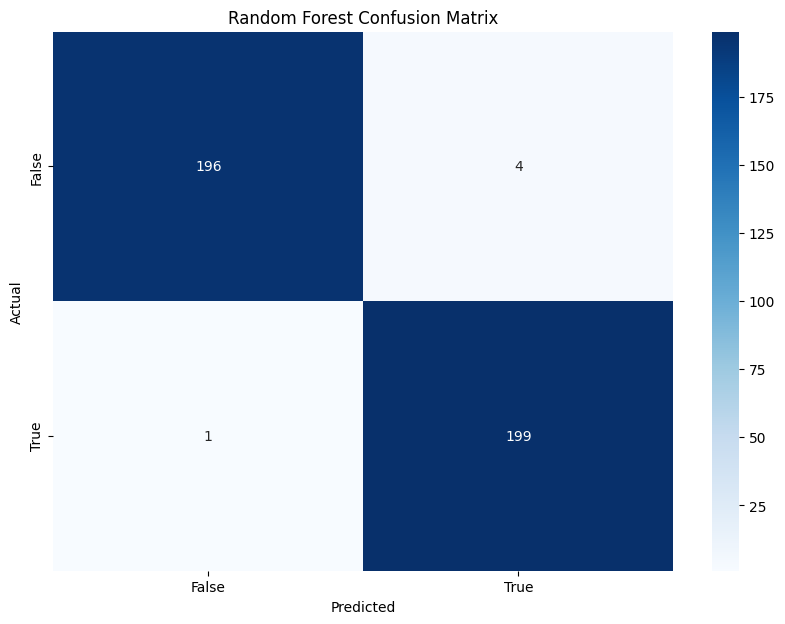

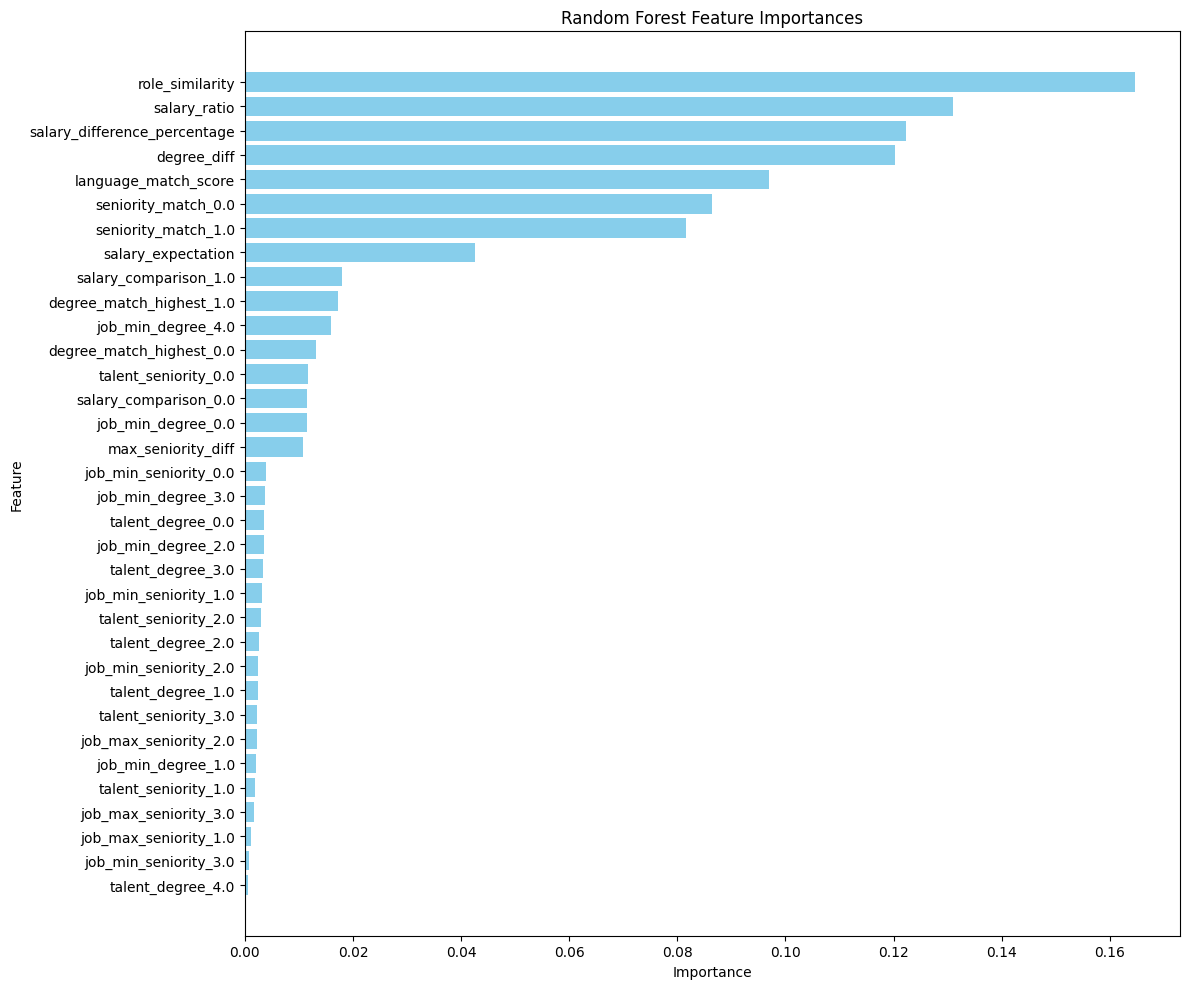

GradientBoostingClassifier Model
[[199   1]
 [  2 198]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



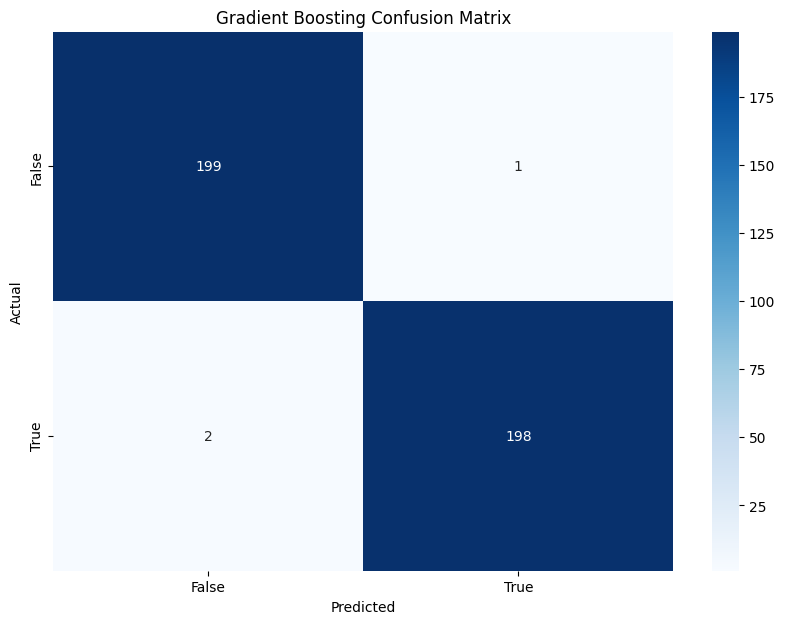

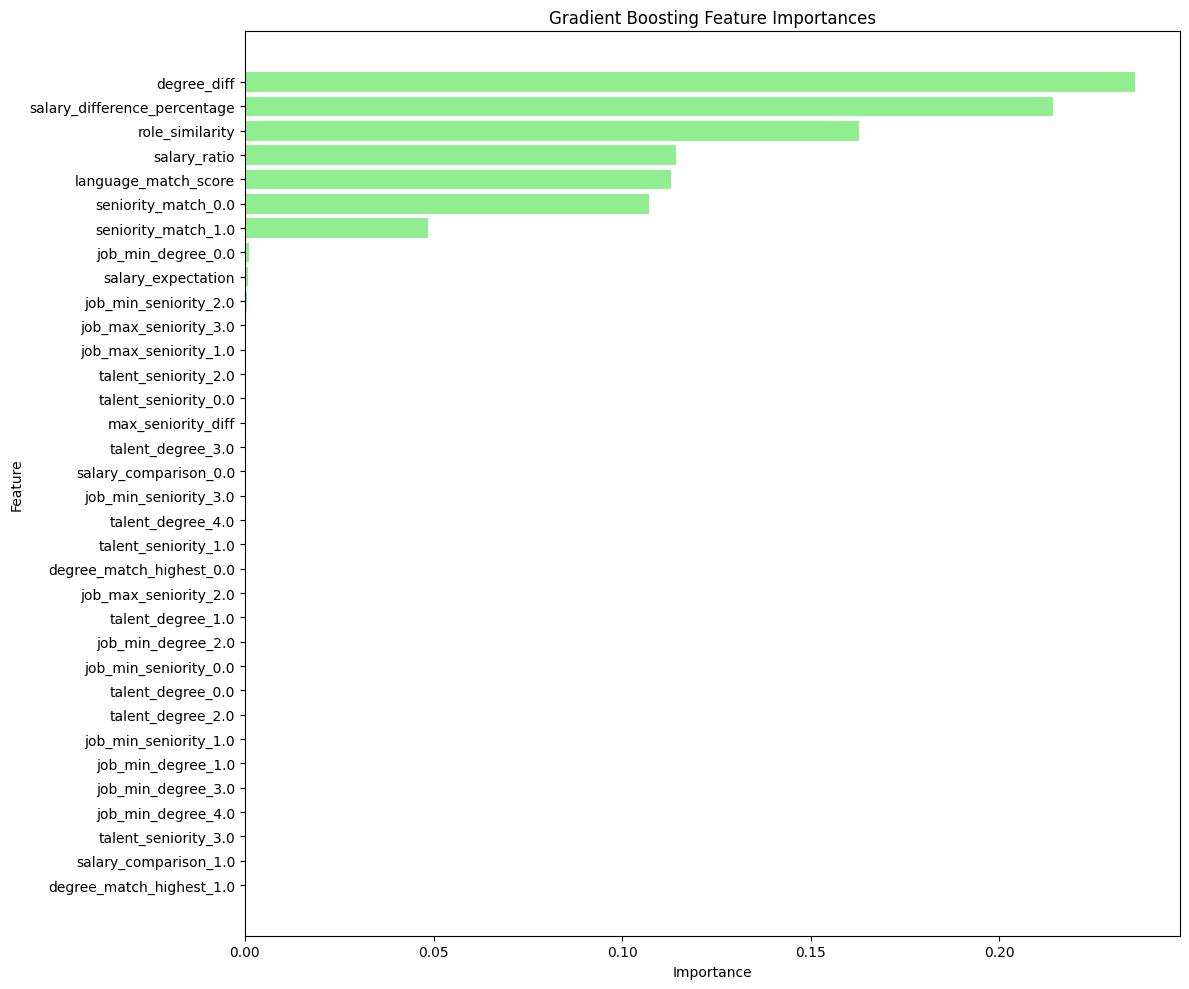

In [5]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

feature_names = feature_engineer.get_feature_names()

# Train the RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

print("Random Forest Model")
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Random Forest Confusion Matrix")

# Get feature importances
rf_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
})

# Sort the DataFrame by importance
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for RandomForest
plt.figure(figsize=(12, 10))
plt.barh(rf_feature_importances_df['Feature'], rf_feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Train the GradientBoosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("GradientBoostingClassifier Model")
y_pred = gb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Gradient Boosting Confusion Matrix")

# Get feature importances
gb_importances = gb_model.feature_importances_

# Create a DataFrame for better visualization
gb_feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_importances
})

# Sort the DataFrame by importance
gb_feature_importances_df = gb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for GradientBoosting
plt.figure(figsize=(12, 10))
plt.barh(gb_feature_importances_df['Feature'], gb_feature_importances_df['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Exploring miss-classifed examples

In [6]:
import pandas as pd
# Convert y_test to a pandas Series with the correct indices
y_test_series = pd.Series(y_test, index=job_df_test.index)

# Predict using the GradientBoosting model
y_pred = gb_model.predict(X_test)

# Get misclassified indices
misclassified_indices = y_test_series[y_test_series != y_pred].index

# Convert X_test to a DataFrame with the correct indices
X_test_df = pd.DataFrame(X_test, columns=feature_engineer.get_feature_names(), index=job_df_test.index)
y_pred_df = pd.Series(y_pred, index=job_df_test.index)

# Extract misclassified examples
misclassified_examples = X_test_df.loc[misclassified_indices]

# Add actual and predicted values to the misclassified examples
misclassified_examples['Actual'] = y_test_series.loc[misclassified_indices].values
misclassified_examples['Predicted'] = y_pred_df.loc[misclassified_indices].values

# Display the misclassified examples
misclassified_examples

,language_match_score,role_similarity,degree_diff,salary_difference_percentage,max_seniority_diff,salary_expectation,salary_ratio,talent_seniority_0.0,talent_seniority_1.0,talent_seniority_2.0,...,job_min_degree_3.0,job_min_degree_4.0,seniority_match_0.0,seniority_match_1.0,salary_comparison_0.0,salary_comparison_1.0,degree_match_highest_0.0,degree_match_highest_1.0,Actual,Predicted
348,0.644406,-0.416091,1.472688,0.578621,-0.774357,-0.453168,0.578621,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,True,False
955,0.644406,0.646933,0.400911,1.206722,0.106846,-0.268840,1.206722,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,True,False
1888,-0.626926,1.259123,0.936799,-0.693827,-0.774357,-0.545332,-0.693827,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,False,True


In [7]:
# get values from original dataframes
df_job = pd.concat([talent_df, job_df, labels_df], axis=1)
df_job.loc[misclassified_indices]

,degree,job_roles,languages,salary_expectation,seniority,job_roles,languages,max_salary,min_degree,seniorities,label
348,3,"[frontend-developer, full-stack-developer, dev...","[{'rating': 5, 'title': 'English'}, {'rating':...",62000,1,[frontend-developer],"[{'title': 'German', 'rating': 5, 'must_have':...",54000,0,[1],True
955,2,[frontend-developer],"[{'rating': 6, 'title': 'German'}, {'rating': ...",66000,1,"[frontend-developer, backend-developer, full-s...","[{'title': 'German', 'rating': 6, 'must_have':...",50000,1,"[1, 2]",True
1888,2,"[frontend-developer, backend-developer, full-s...","[{'rating': 1, 'title': 'German'}, {'rating': ...",60000,3,"[frontend-developer, backend-developer, full-s...","[{'title': 'German', 'rating': 3, 'must_have':...",75000,0,"[2, 3]",False


## Save Models

In [9]:
import joblib
from datetime import datetime

# Get the current date and time
current_time = datetime.now()

# Format the date as day_month_year
formatted_time = current_time.strftime("%d_%m_%Y")

model_path = f"../models_artifacts/model_{formatted_time}.joblib"

# Save the model and feature engineer to specified path
joblib.dump(gb_model, model_path)
joblib.dump(feature_engineer, model_path.replace('model_', 'feature_engineer'))
        

['../models_artifacts/feature_engineer03_08_2024.joblib']

## Appendix

In Appendix section, I experimenting with more machine learning models and applying cross-validation techniques. The goal was to further explore the performance of the machine learning pipeline for talent-job matching.

#### Additional Models

I tested the following classifiers for comparison:
- **RandomForestClassifier**: Uses multiple decision trees to improve accuracy and control overfitting.
- **GradientBoostingClassifier**: Builds trees sequentially, with each new tree correcting errors from the previous ones.
- **AdaBoostClassifier**: Focuses on hard-to-classify instances by adjusting the weights of incorrectly classified examples.
- **LogisticRegression**: A linear model for binary classification that estimates the probability of a default class.
- **SVC (Support Vector Classifier)**: A powerful classifier that works well in high-dimensional spaces, maximizing the margin between classes.
- **KNeighborsClassifier**: A non-parametric method that classifies based on the closest training examples in the feature space.
- **DecisionTreeClassifier**: Splits the data into subsets based on feature values, providing a simple and interpretable model.

#### Cross-Validation

To ensure robustness and reliability, I implemented **cross-validation**. This technique involves splitting the data into several subsets, training the model on some subsets while validating on the remaining ones. This approach helps:

1. **Reduce Overfitting**: By validating on multiple data splits, the model is more likely to generalize well to unseen data.
2. **Estimate Performance**: Cross-validation provides a more accurate measure of model performance compared to a simple train/test split.

Training RandomForest...
RandomForest Train Accuracy: 1.00
RandomForest Test Accuracy: 0.99
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



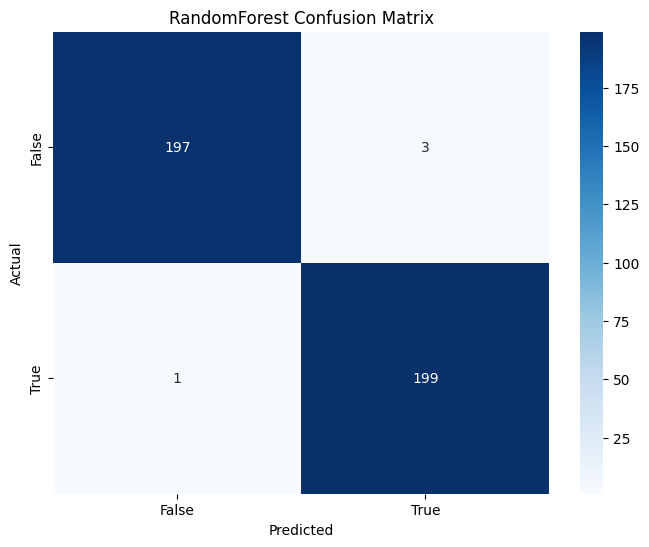

Training GradientBoosting...
GradientBoosting Train Accuracy: 1.00
GradientBoosting Test Accuracy: 0.99
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



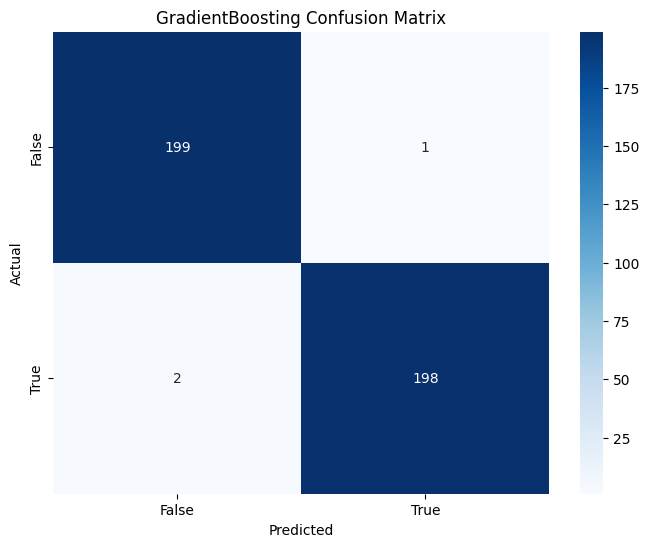

Training XGBoost...
XGBoost Train Accuracy: 1.00
XGBoost Test Accuracy: 0.98
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       200
        True       0.98      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



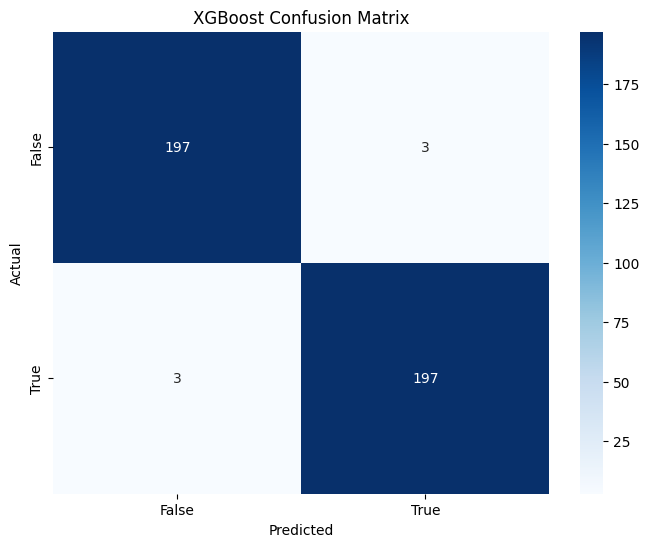

Training AdaBoost...
AdaBoost Train Accuracy: 0.99
AdaBoost Test Accuracy: 0.99
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



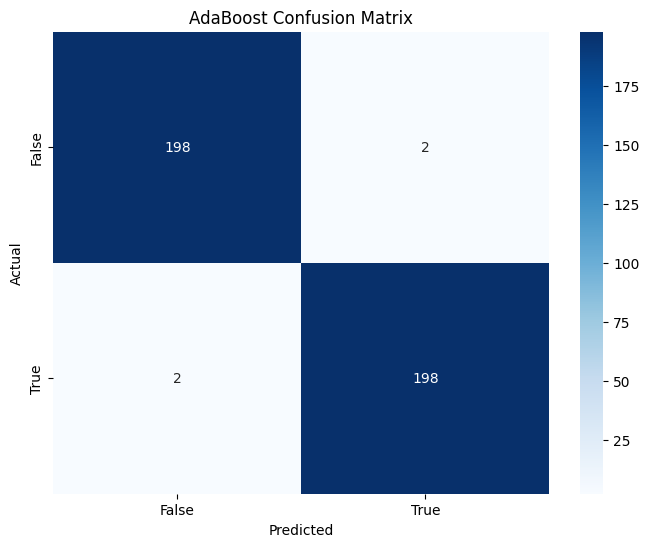

Training LogisticRegression...
LogisticRegression Train Accuracy: 0.95
LogisticRegression Test Accuracy: 0.95
              precision    recall  f1-score   support

       False       0.95      0.94      0.95       200
        True       0.94      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



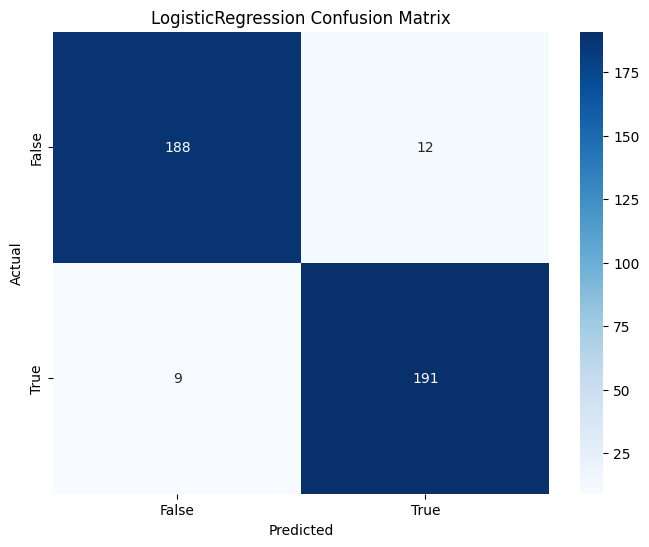

Training SVC...
SVC Train Accuracy: 0.98
SVC Test Accuracy: 0.98
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       200
        True       0.97      0.99      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



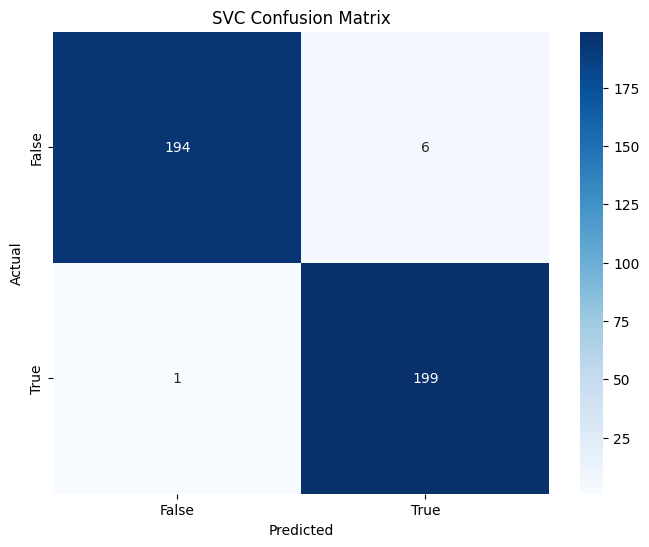

Training KNeighbors...
KNeighbors Train Accuracy: 0.95
KNeighbors Test Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.99      0.84      0.91       200
        True       0.86      0.99      0.92       200

    accuracy                           0.92       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.92      0.92       400



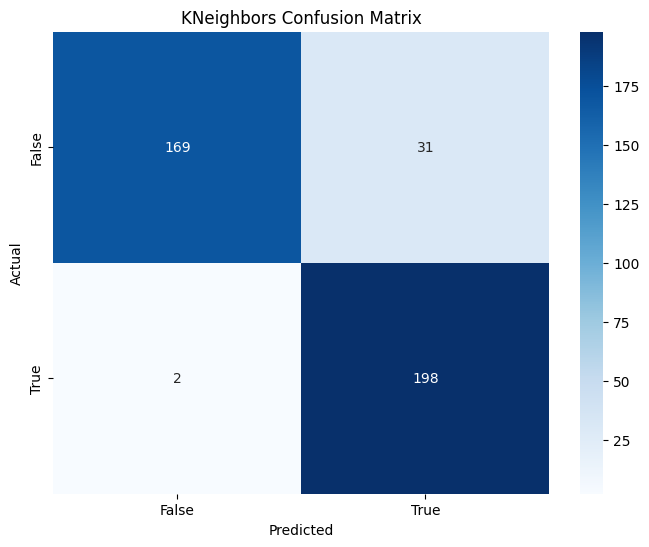

Training DecisionTree...
DecisionTree Train Accuracy: 1.00
DecisionTree Test Accuracy: 0.98
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       200
        True       0.98      0.97      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



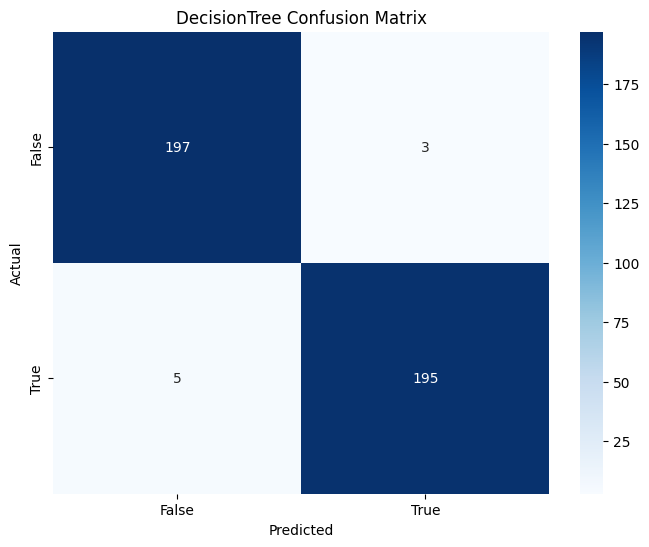

In [32]:
# List of models to try
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    print(f"{model_name} Train Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    
    # Predict and generate classification report
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

### Cross Validation

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier(),
}

# cross-validation data preparation
features = feature_engineer.fit_transform(job_df, talent_df)

# Implement cross-validation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, features, labels_df['label'], cv=5)
    print(f"{model_name} Cross-validation scores: {cv_scores}")
    print(f"{model_name} Mean CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Feature selection
selector = SelectKBest(f_classif, k=10)  # Select top 10 features
X_new = selector.fit_transform(features, labels_df['label'])

# Get feature importance for tree-based models
if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier)):
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': range(features.shape[1]), 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print(feature_importance.head(10))  # Print top 10 important features

# Add some noise to features
noisy_features = features + np.random.normal(0, 0.1, features.shape)

RandomForest Cross-validation scores: [0.99   0.99   0.9875 0.9875 0.98  ]
RandomForest Mean CV score: 0.99 (+/- 0.01)
GradientBoosting Cross-validation scores: [0.9875 0.99   0.98   0.985  0.98  ]
GradientBoosting Mean CV score: 0.98 (+/- 0.01)
AdaBoost Cross-validation scores: [0.99   0.99   0.98   0.9875 0.98  ]
AdaBoost Mean CV score: 0.99 (+/- 0.01)
LogisticRegression Cross-validation scores: [0.945  0.9475 0.9275 0.945  0.945 ]
LogisticRegression Mean CV score: 0.94 (+/- 0.01)
SVC Cross-validation scores: [0.9725 0.9875 0.97   0.975  0.9625]
SVC Mean CV score: 0.97 (+/- 0.02)
KNeighbors Cross-validation scores: [0.94   0.915  0.9425 0.915  0.935 ]
KNeighbors Mean CV score: 0.93 (+/- 0.02)
